In [143]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D,MaxPooling2D, Flatten, Dense, Dropout
import os, io,zipfile,time
from PIL import Image
import tqdm
import cv2
from pathlib import Path
import joblib
from keras.preprocessing import image

from tensorflow.keras.layers import Add, Dense, ReLU, Reshape, LeakyReLU



In [144]:
# load data - data has training (tumor,no-tumor) and test (tumor,no-tumor) datasets

zip_file_path=("/content/MRIBrainTumor.zip")
extracted_dir=("/content/extracted_data")
!mkdir -p $extracted_dir
with zipfile.ZipFile(zip_file_path,'r') as zip_ref:
  zip_ref.extractall(extracted_dir)
!ls $extracted_dir

Testing  Training


In [197]:
from pathlib import Path
from keras.preprocessing import image
import numpy as np

# path_to_no_tumor_directory and "path_to_pituitary_tumor_directory"
no_tumor_path = Path("/content/extracted_data/Training/no_tumor")
pituitary_tumor_path = Path("/content/extracted_data/Training/pituitary_tumor")

images = []
labels = []

for img_path in no_tumor_path.glob("*jpg"):
    img = image.load_img(img_path, target_size=(64, 64))
    img_array = image.img_to_array(img)
    images.append(img_array)
    labels.append(0)

for img_path in pituitary_tumor_path.glob("*jpg"):
    img = image.load_img(img_path, target_size=(64, 64))
    img_array = image.img_to_array(img)
    images.append(img_array)
    labels.append(1)

xtrain = np.array(images)
ytrain = np.array(labels)


In [198]:
ytrain.shape #(1222,)
xtrain.shape  #(1222, 224, 224, 1)

(1222, 64, 64, 3)

In [199]:
#scale between -1 and 1  (negative: fake images by generator)
xtrain=xtrain.astype('float32')
xtrain=(xtrain-127.5)/127.5


In [202]:
buffer_size=1222  #shuffle images
batch_size=32  #128
train_dataset=tf.data.Dataset.from_tensor_slices(xtrain).shuffle(buffer_size).batch(batch_size)

# creates a dataset from the training images, shuffles the dataset, and batches the shuffled elements into batches of a specified size, making it suitable for training the model.
# creates a tensorflow dataset (train_dataset) from a tensor of training images by slicing it along the first dimension- each element of the dataset will correspond to one element of the tensor (xtrain), preserving their order.

In [203]:
init_weights_kernel=tf.initializers.RandomNormal(mean=0.0,stddev=0.02)
# random normal kernel to initialize the weights of the layers of my model - a Gaussian kernel with the mean and std dev

In [204]:
def generator_model():
  model=tf.keras.Sequential()

  model.add(layers.Input(shape=(100,)))   # noise vector
  model.add(layers.Dense(4*4*256))        # 4d
  model.add(layers.BatchNormalization())
  model.add(layers.ReLU())
  model.add(layers.Reshape((4,4,256)))

  model.add(layers.Conv2DTranspose(128,kernel_size=4,strides=2,padding='same',kernel_initializer=init_weights_kernel,
                                   use_bias=False))
  model.add(layers.BatchNormalization())
  model.add(layers.ReLU())

  model.add(layers.Conv2DTranspose(64,kernel_size=4,strides=2,padding='same',kernel_initializer=init_weights_kernel,
                                   use_bias=False))
  model.add(layers.BatchNormalization())
  model.add(layers.ReLU())

  model.add(layers.Conv2DTranspose(32,kernel_size=4,strides=2,padding='same',kernel_initializer=init_weights_kernel,
                                   use_bias=False))
  model.add(layers.BatchNormalization())
  model.add(layers.ReLU())

  model.add(layers.Conv2DTranspose(3, kernel_size=4,strides=2,padding='same', activation='tanh',
                                   kernel_initializer=init_weights_kernel, use_bias=False))  # 3 channel
# tanh: -1 to 1
  return model


In [205]:
generator = generator_model()
generator.summary()

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_62 (Dense)            (None, 4096)              413696    
                                                                 
 batch_normalization_37 (Ba  (None, 4096)              16384     
 tchNormalization)                                               
                                                                 
 re_lu_37 (ReLU)             (None, 4096)              0         
                                                                 
 reshape_12 (Reshape)        (None, 4, 4, 256)         0         
                                                                 
 conv2d_transpose_19 (Conv2  (None, 8, 8, 128)         524288    
 DTranspose)                                                     
                                                                 
 batch_normalization_38 (Ba  (None, 8, 8, 128)       

In [206]:
noise=tf.random.normal([1,100])  # generate Gaussian noise: vector size is 100= input dimension of our generator model
generated_image=generator(noise,training=False)  # False: see the generated img looks like
generated_image.shape

TensorShape([1, 64, 64, 3])

In [207]:
generated_image[0,:5,:5]

<tf.Tensor: shape=(5, 5, 3), dtype=float32, numpy=
array([[[-4.59241164e-05, -1.28699205e-04, -7.27404768e-07],
        [ 3.10292875e-04, -1.50189400e-04,  8.17600667e-05],
        [-2.21574621e-04,  5.54534163e-05,  6.38616038e-05],
        [-8.37671978e-05, -3.01211869e-04, -3.15450947e-04],
        [-3.50989460e-04,  4.27051200e-05,  1.09193192e-04]],

       [[-3.24878667e-04,  1.77490874e-04,  2.34985855e-05],
        [ 1.26396044e-05, -4.01600089e-04,  3.23551707e-04],
        [-4.64566474e-05,  4.96777531e-04,  5.62688743e-04],
        [-3.57363344e-04,  3.91291396e-04,  2.83883826e-04],
        [ 6.04556641e-04,  4.22780722e-04, -8.13443970e-04]],

       [[-4.27266117e-04,  1.58167386e-04, -5.71354758e-05],
        [-2.70079880e-04, -1.62542507e-04, -2.62885471e-04],
        [-3.73681658e-04, -6.20795836e-05,  1.94760709e-04],
        [-1.04738559e-04, -1.03376259e-03, -1.07719761e-03],
        [-8.92377226e-04,  7.54300156e-04,  5.55007136e-04]],

       [[-2.72988924e-04, -1

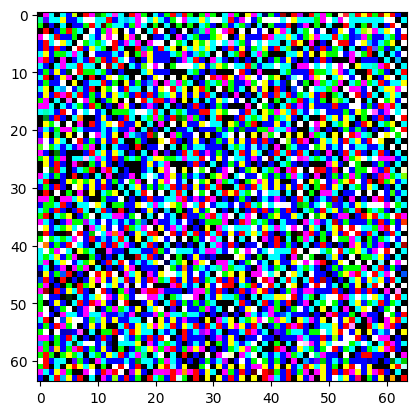

In [208]:
plt.imshow(generated_image[0,:,:,:]*255*100)
# noise - color - 60 pixels *60 pixels

In [209]:
def discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(32,kernel_size=3,strides=2,padding='same',input_shape=[64,64,3],
                            kernel_initializer=init_weights_kernel, use_bias=False))
    model.add(layers.LeakyReLU(alpha=0.2)) # slight gradient for input values below zero: controlled by the input argument (o.2) that we pass into LR
    model.add(layers.Dropout(0.3)) # dropout: overfitting : turning off a % of neurons in the layer

    model.add(layers.Conv2D(64,kernel_size=3,strides=2,padding='same',input_shape=[64,64,3],
                            kernel_initializer=init_weights_kernel, use_bias=False))
    model.add(layers.ZeroPadding2D(padding=((0,1),(0,1)))) # slight gradient for input values below zero: controlled by the input argument (o.2) that we pass into LR
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(0.2)) # slight gradient for input values below zero: controlled by the input argument (0.2) that we pass into LR
    model.add(layers.Dropout(0.25)) # dropout: overfitting : turning off a % of neurons in the layer

    model.add(layers.Conv2D(128,kernel_size=3,strides=2,padding='same',input_shape=[64,64,3],
                            kernel_initializer=init_weights_kernel, use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(256,kernel_size=3,strides=2,padding='same',input_shape=[64,64,3],
                            kernel_initializer=init_weights_kernel, use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid')) # single probability score: represent the prob that input img is real - sigmoid : prob score : 0-1

    return model


In [210]:
discriminator=discriminator_model()
discriminator.summary()

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 32, 32, 32)        864       
                                                                 
 leaky_re_lu_38 (LeakyReLU)  (None, 32, 32, 32)        0         
                                                                 
 dropout_38 (Dropout)        (None, 32, 32, 32)        0         
                                                                 
 conv2d_21 (Conv2D)          (None, 16, 16, 64)        18432     
                                                                 
 zero_padding2d_2 (ZeroPadd  (None, 17, 17, 64)        0         
 ing2D)                                                          
                                                                 
 batch_normalization_41 (Ba  (None, 17, 17, 64)        256       
 tchNormalization)                                   

In [211]:
discriminator=discriminator_model()
output=discriminator(generated_image)
print(output)
# img (noise) from untrained generated model and pass this through the untrained discriminator ->  probability score: % 49

tf.Tensor([[0.50000024]], shape=(1, 1), dtype=float32)


In [212]:
bce=tf.keras.losses.BinaryCrossentropy()  # loss function

In [213]:
def discriminator_loss(real_output,fake_output):
  # 2 classes 1: real and 0:fake # imgs from real dataset classfied as real
  real_loss=bce(tf.ones_like(real_output),real_output) # compare output of discriminator to a tensor of 1s, this loss = real loss of the discriminator
  fake_loss=bce(tf.zeros_like(fake_output),fake_output) # tensor of 0s #fake binary crossentropy loss
  total_loss=real_loss+fake_loss # try to min total loss or max probabilty real imgs classifed as real and generated imgs are classfied as fake
  return total_loss


In [214]:
# Traning GANs # 2 Networks
# generator loss
def generator_loss(fake_output):
  gen_loss=bce(tf.ones_like(fake_output),fake_output) # input is fake_output = output of discriminator for fake data generated by the generator & compare the output to a tensor of all 1s
  # objective: fools discriminator: classifies fake data as real
  return gen_loss

In [215]:
# optimizers for both # Adam preforms gredient descent using an exponentially weighted average of gradients
generator_optimizer=tf.keras.optimizers.Adam(learning_rate=0.002,beta_1=0.5)
discriminator_optimizer=tf.keras.optimizers.Adam(learning_rate=0.002,beta_1=0.5)

In [216]:
# training  # interrupt start from the last checkpoint
import os
import tensorflow as tf
from tensorflow.keras.optimizers import Adam

# Specify the directory to save checkpoints
checkpoint_dir = './training_checkpoints'
checkpoint_prefix=os.path.join(checkpoint_dir,'ckpt')

# Create a tf.train.Checkpoint object
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)


In [217]:
# training process
epochs=40
noise_dim=100
num_examples_to_generate=16 # after epoch of training , generate 16 examples from our GAN to see that what the generated images looked like; these 10 images generated usign 16 different noise vectors, each dimensionality 100

seed=tf.random.normal([num_examples_to_generate,noise_dim])

In [218]:
# helper function generate & plot images to get the generator to generate images form the test input that we have specified
def generate_and_plot_images(model,epoch,test_input):
  predictions=model(test_input,training=False) # output of generator for test noise input that we set up earlier
  fig=plt.figure(figsize=(8,4)) # plot this output to see how the generator improves over time

  for i in range (predictions.shape[0]):
    plt.subplot(4,4,i+1)
    plt.imshow((predictions[i,:,:,:]*0.5+0.5))
    plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [219]:
@tf.function() #python animation as a transformation tool & creates data flow graphs out of ur Py code # generate NN graph
def train_step(images):  # images as input
  noise=tf.random.normal([batch_size,noise_dim]) # @ every step generate a batch of noise
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape: # GradientTape : gradient descent -> train NN - 2 types of NN
    generated_images=generator(noise,training=True) #generate fake images from generator -> trainign true

    real_output=discriminator(images,training=True) # train discriminator : real and fake images
    fake_output=discriminator(generated_images,training=True)

    disc_loss=discriminator_loss(real_output,fake_output)
    gen_loss=generator_loss(fake_output)

  gradient_of_generator=gen_tape.gradient(gen_loss,generator.trainable_variables)
  gradient_of_discriminator=disc_tape.gradient(disc_loss,discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(gradient_of_generator, generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(gradient_of_discriminator, discriminator.trainable_variables))

  return(gen_loss,disc_loss,tf.reduce_mean(real_output),tf.reduce_mean(fake_output))
  # return losses and accuracy of discriminator on real data and fake data

In [220]:
# actual training
def train(dataset,epochs):
  gen_loss_list=[]
  disc_loss_list=[] # for plotting
  real_score_list=[]
  fake_score_list=[] # accuracy

  for epoch in tqdm(range(epochs)):
    start=time.time()
    num_batches=len(dataset)

    print(f'Training started with epochs {epoch+1} with {num_batches} bateches...')

    total_gen_loss=0
    total_disc_loss=0

    for batch in dataset:
      generator_loss, discriminator_loss,real_score, fake_score=train_step(batch)
      total_gen_loss+=generator_loss
      total_disc_loss+=discriminator_loss

    mean_gen_loss=total_gen_loss/num_batches # average loss for epoch
    mean_disc_loss=total_disc_loss/num_batches

    print(f'Losses after epoch %5d: generator %.3f, discriminator %.3f,  real_score %.2f%%, fake_score %.2f%%' %
      (epoch+1, generator_loss, discriminator_loss, real_score * 100, fake_score * 100))

    generate_and_plot_images(generator, epoch+1,seed)

    gen_loss_list.append(mean_gen_loss)
    disc_loss_list.append(mean_disc_loss)
    real_score_list.append(real_score)  # accuracy
    fake_score_list.append(fake_score)

    if (epoch+1)%10==0:
      checkpoint.save(file_prefix=checkpoint_prefix)

    print('Time for epoch {} is {} sec'.format(epoch+1, time.time()-start))

  return gen_loss_list, disc_loss_list,real_score_list,fake_score_list


  0%|          | 0/40 [00:00<?, ?it/s]

Training started with epochs 1 with 39 bateches...
Losses after epoch     1: generator 4.512, discriminator 0.033,  real_score 99.90%, fake_score 3.05%


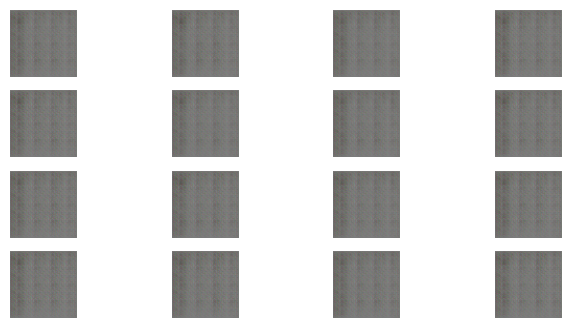

  2%|▎         | 1/40 [00:09<06:00,  9.25s/it]

Time for epoch 1 is 9.252016305923462 sec
Training started with epochs 2 with 39 bateches...
Losses after epoch     2: generator 1.219, discriminator 1.361,  real_score 58.67%, fake_score 40.10%


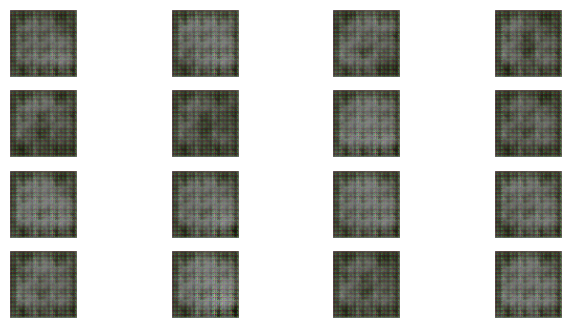

  5%|▌         | 2/40 [00:10<02:47,  4.41s/it]

Time for epoch 2 is 1.016768217086792 sec
Training started with epochs 3 with 39 bateches...
Losses after epoch     3: generator 2.270, discriminator 0.921,  real_score 53.09%, fake_score 16.02%


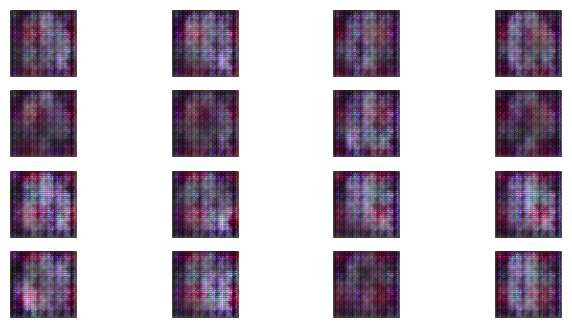

  8%|▊         | 3/40 [00:11<01:45,  2.85s/it]

Time for epoch 3 is 0.9930295944213867 sec
Training started with epochs 4 with 39 bateches...
Losses after epoch     4: generator 1.541, discriminator 0.469,  real_score 93.72%, fake_score 29.99%


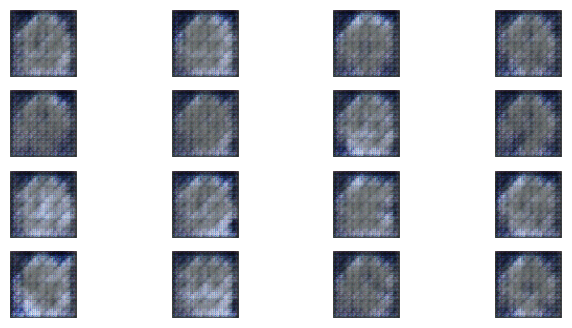

 10%|█         | 4/40 [00:12<01:16,  2.13s/it]

Time for epoch 4 is 1.0279223918914795 sec
Training started with epochs 5 with 39 bateches...
Losses after epoch     5: generator 2.617, discriminator 0.173,  real_score 99.12%, fake_score 13.45%


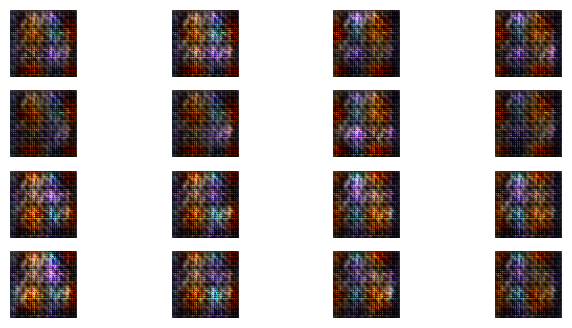

 12%|█▎        | 5/40 [00:13<01:00,  1.73s/it]

Time for epoch 5 is 1.0078864097595215 sec
Training started with epochs 6 with 39 bateches...
Losses after epoch     6: generator 15.821, discriminator 7.484,  real_score 16.70%, fake_score 0.00%


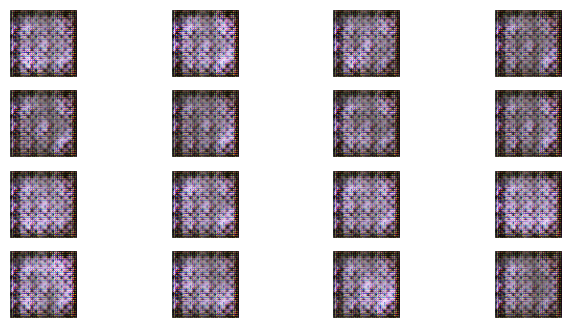

 15%|█▌        | 6/40 [00:14<00:50,  1.50s/it]

Time for epoch 6 is 1.0453522205352783 sec
Training started with epochs 7 with 39 bateches...
Losses after epoch     7: generator 0.560, discriminator 1.566,  real_score 99.25%, fake_score 67.94%


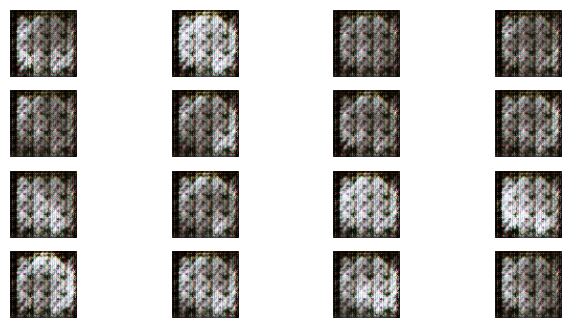

 18%|█▊        | 7/40 [00:15<00:47,  1.43s/it]

Time for epoch 7 is 1.2856225967407227 sec
Training started with epochs 8 with 39 bateches...
Losses after epoch     8: generator 1.211, discriminator 0.899,  real_score 82.98%, fake_score 43.21%


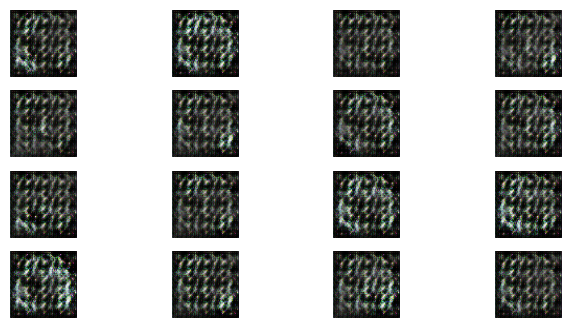

 20%|██        | 8/40 [00:17<00:48,  1.52s/it]

Time for epoch 8 is 1.7076573371887207 sec
Training started with epochs 9 with 39 bateches...
Losses after epoch     9: generator 3.565, discriminator 0.399,  real_score 78.54%, fake_score 4.63%


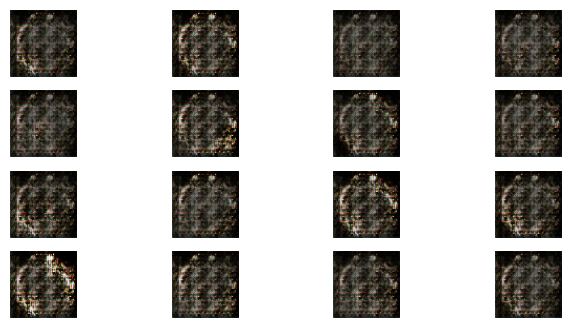

 22%|██▎       | 9/40 [00:18<00:42,  1.36s/it]

Time for epoch 9 is 1.0119619369506836 sec
Training started with epochs 10 with 39 bateches...
Losses after epoch    10: generator 0.977, discriminator 0.932,  real_score 89.37%, fake_score 48.33%


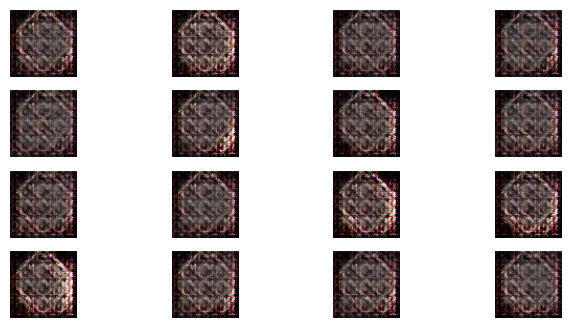

 25%|██▌       | 10/40 [00:19<00:39,  1.32s/it]

Time for epoch 10 is 1.217071533203125 sec
Training started with epochs 11 with 39 bateches...
Losses after epoch    11: generator 1.387, discriminator 1.584,  real_score 55.65%, fake_score 36.50%


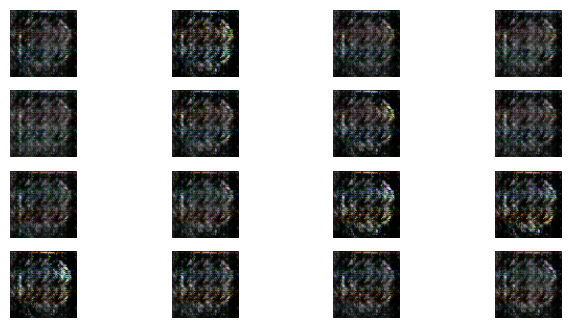

 28%|██▊       | 11/40 [00:20<00:35,  1.23s/it]

Time for epoch 11 is 1.0165154933929443 sec
Training started with epochs 12 with 39 bateches...
Losses after epoch    12: generator 1.208, discriminator 0.987,  real_score 72.54%, fake_score 42.38%


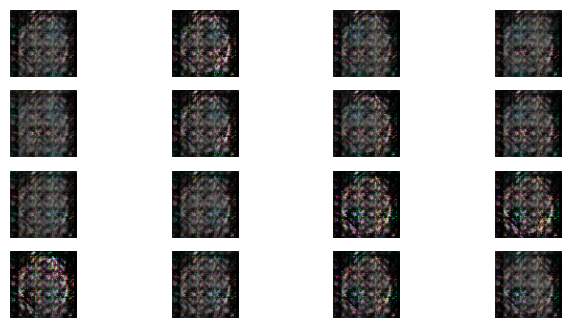

 30%|███       | 12/40 [00:21<00:32,  1.18s/it]

Time for epoch 12 is 1.0637905597686768 sec
Training started with epochs 13 with 39 bateches...
Losses after epoch    13: generator 5.030, discriminator 1.189,  real_score 52.51%, fake_score 2.25%


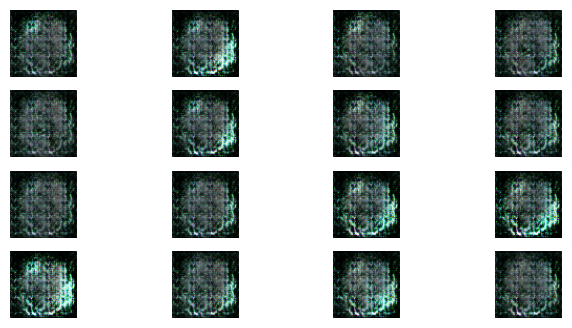

 32%|███▎      | 13/40 [00:22<00:30,  1.13s/it]

Time for epoch 13 is 1.018430233001709 sec
Training started with epochs 14 with 39 bateches...
Losses after epoch    14: generator 2.081, discriminator 0.331,  real_score 95.31%, fake_score 21.21%


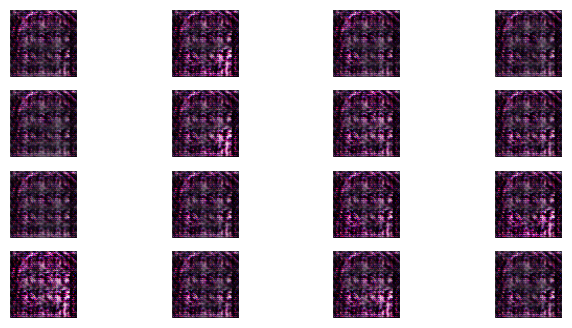

 35%|███▌      | 14/40 [00:24<00:32,  1.27s/it]

Time for epoch 14 is 1.5733771324157715 sec
Training started with epochs 15 with 39 bateches...
Losses after epoch    15: generator 4.718, discriminator 0.113,  real_score 91.33%, fake_score 1.92%


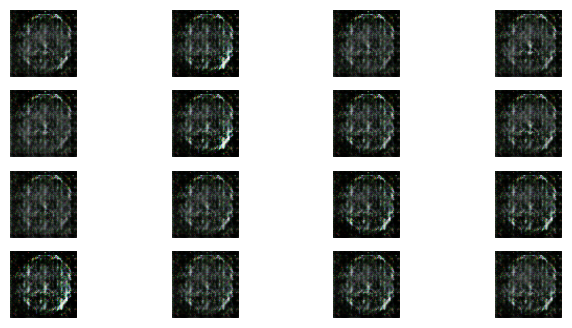

 38%|███▊      | 15/40 [00:25<00:30,  1.20s/it]

Time for epoch 15 is 1.059196949005127 sec
Training started with epochs 16 with 39 bateches...
Losses after epoch    16: generator 3.702, discriminator 0.549,  real_score 67.73%, fake_score 5.59%


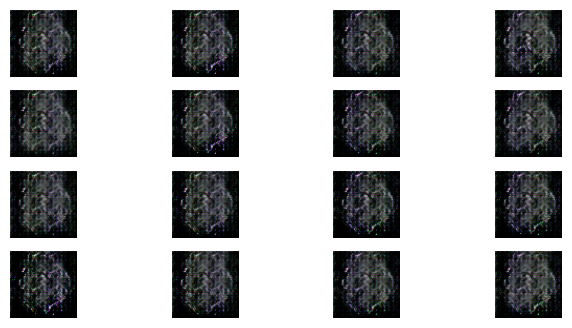

 40%|████      | 16/40 [00:26<00:27,  1.15s/it]

Time for epoch 16 is 1.0347695350646973 sec
Training started with epochs 17 with 39 bateches...
Losses after epoch    17: generator 1.574, discriminator 0.638,  real_score 84.39%, fake_score 30.18%


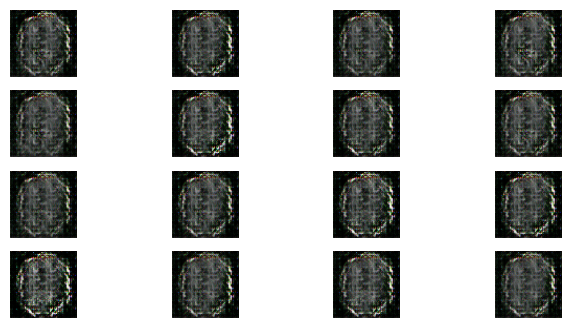

 42%|████▎     | 17/40 [00:27<00:28,  1.22s/it]

Time for epoch 17 is 1.3665664196014404 sec
Training started with epochs 18 with 39 bateches...
Losses after epoch    18: generator 0.398, discriminator 4.303,  real_score 48.76%, fake_score 75.55%


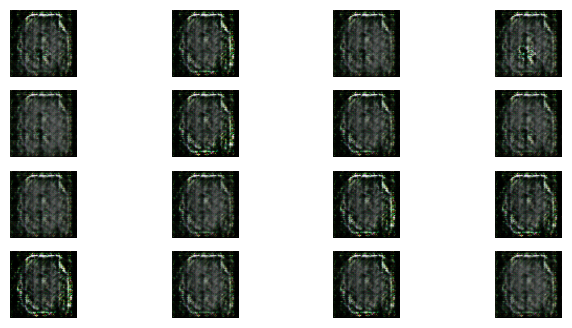

 45%|████▌     | 18/40 [00:28<00:26,  1.22s/it]

Time for epoch 18 is 1.2279052734375 sec
Training started with epochs 19 with 39 bateches...
Losses after epoch    19: generator 2.093, discriminator 0.877,  real_score 66.78%, fake_score 20.94%


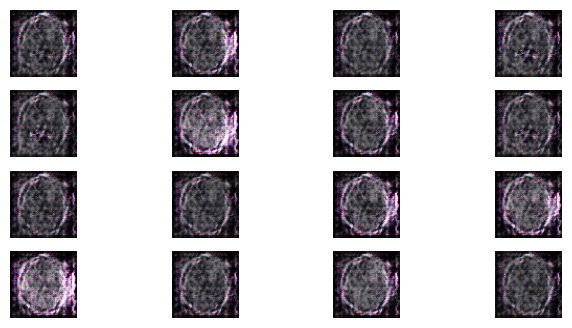

 48%|████▊     | 19/40 [00:29<00:24,  1.16s/it]

Time for epoch 19 is 1.0126957893371582 sec
Training started with epochs 20 with 39 bateches...
Losses after epoch    20: generator 1.574, discriminator 0.503,  real_score 95.18%, fake_score 31.42%


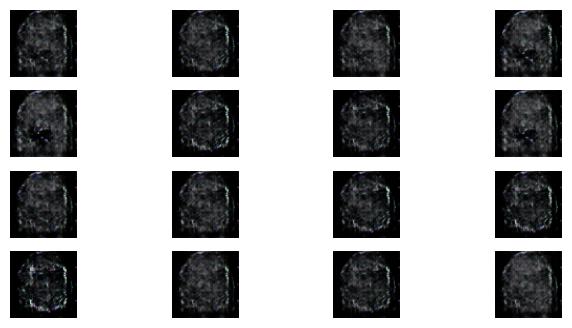

 50%|█████     | 20/40 [00:31<00:23,  1.18s/it]

Time for epoch 20 is 1.224349021911621 sec
Training started with epochs 21 with 39 bateches...
Losses after epoch    21: generator 3.921, discriminator 1.486,  real_score 48.93%, fake_score 8.04%


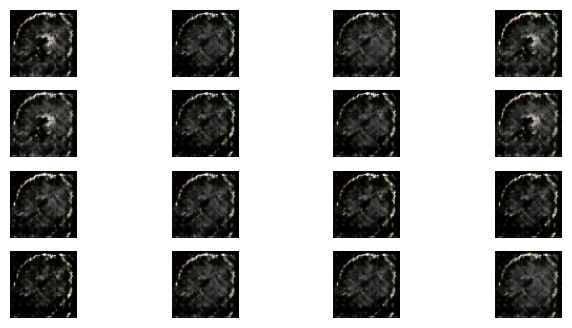

 52%|█████▎    | 21/40 [00:32<00:24,  1.26s/it]

Time for epoch 21 is 1.4600484371185303 sec
Training started with epochs 22 with 39 bateches...
Losses after epoch    22: generator 3.389, discriminator 0.192,  real_score 93.66%, fake_score 8.47%


 55%|█████▌    | 22/40 [00:33<00:21,  1.20s/it]

Time for epoch 22 is 1.0426476001739502 sec
Training started with epochs 23 with 39 bateches...
Losses after epoch    23: generator 2.637, discriminator 0.561,  real_score 85.60%, fake_score 20.83%


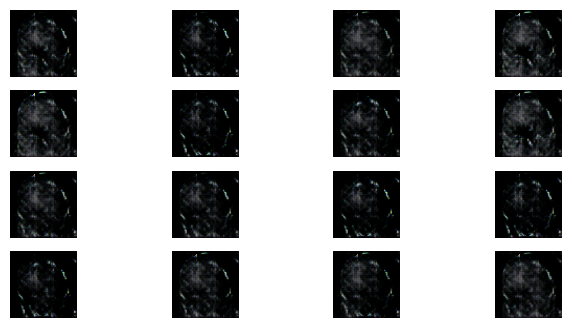

 57%|█████▊    | 23/40 [00:34<00:19,  1.15s/it]

Time for epoch 23 is 1.0409393310546875 sec
Training started with epochs 24 with 39 bateches...
Losses after epoch    24: generator 2.755, discriminator 1.174,  real_score 62.21%, fake_score 13.05%


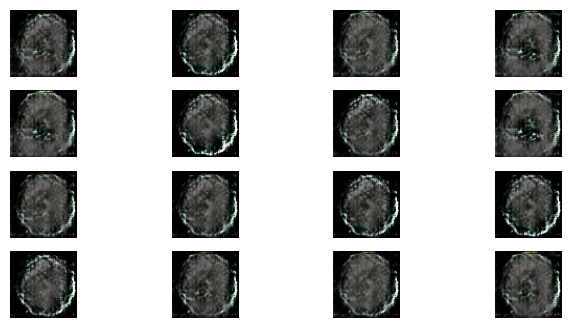

 60%|██████    | 24/40 [00:35<00:17,  1.12s/it]

Time for epoch 24 is 1.0579991340637207 sec
Training started with epochs 25 with 39 bateches...
Losses after epoch    25: generator 5.585, discriminator 1.223,  real_score 40.49%, fake_score 1.13%


 62%|██████▎   | 25/40 [00:36<00:16,  1.09s/it]

Time for epoch 25 is 1.018784761428833 sec
Training started with epochs 26 with 39 bateches...
Losses after epoch    26: generator 2.752, discriminator 0.323,  real_score 88.52%, fake_score 13.31%


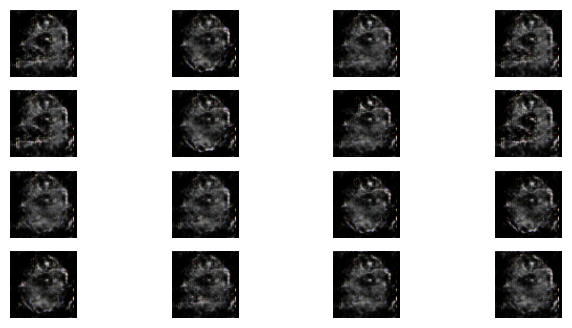

 65%|██████▌   | 26/40 [00:37<00:15,  1.07s/it]

Time for epoch 26 is 1.0200176239013672 sec
Training started with epochs 27 with 39 bateches...
Losses after epoch    27: generator 1.058, discriminator 1.227,  real_score 98.12%, fake_score 54.62%


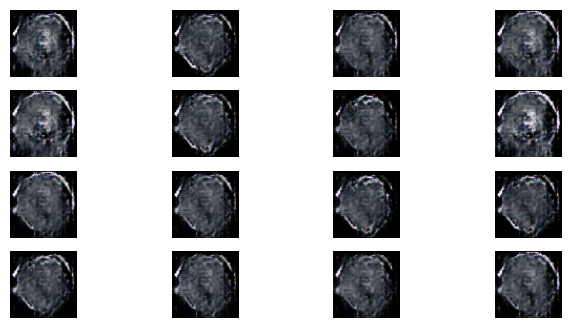

 68%|██████▊   | 27/40 [00:39<00:14,  1.09s/it]

Time for epoch 27 is 1.1260879039764404 sec
Training started with epochs 28 with 39 bateches...
Losses after epoch    28: generator 2.560, discriminator 0.269,  real_score 97.72%, fake_score 17.81%


 70%|███████   | 28/40 [00:41<00:18,  1.51s/it]

Time for epoch 28 is 2.4745845794677734 sec
Training started with epochs 29 with 39 bateches...
Losses after epoch    29: generator 4.576, discriminator 0.189,  real_score 86.05%, fake_score 3.13%


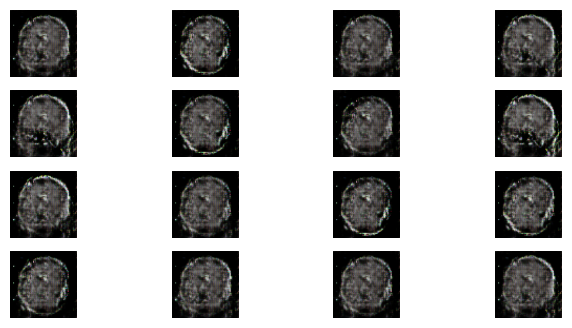

 72%|███████▎  | 29/40 [00:43<00:17,  1.55s/it]

Time for epoch 29 is 1.652428150177002 sec
Training started with epochs 30 with 39 bateches...
Losses after epoch    30: generator 7.361, discriminator 0.673,  real_score 60.00%, fake_score 0.22%


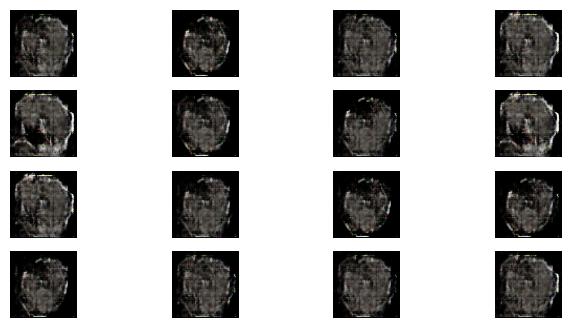

 75%|███████▌  | 30/40 [00:44<00:15,  1.56s/it]

Time for epoch 30 is 1.5662841796875 sec
Training started with epochs 31 with 39 bateches...
Losses after epoch    31: generator 1.713, discriminator 0.568,  real_score 94.77%, fake_score 29.78%


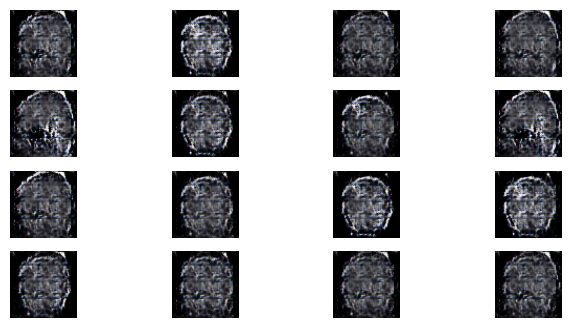

 78%|███████▊  | 31/40 [00:45<00:12,  1.40s/it]

Time for epoch 31 is 1.0267512798309326 sec
Training started with epochs 32 with 39 bateches...
Losses after epoch    32: generator 3.361, discriminator 0.280,  real_score 88.64%, fake_score 8.45%


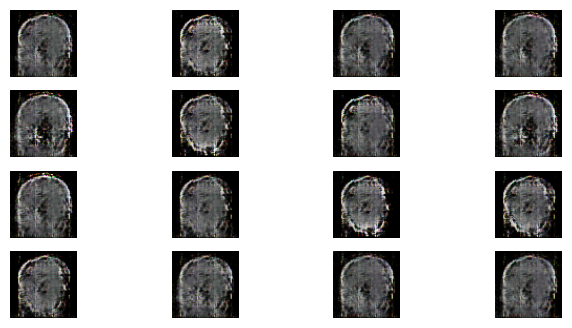

 80%|████████  | 32/40 [00:46<00:10,  1.29s/it]

Time for epoch 32 is 1.043210506439209 sec
Training started with epochs 33 with 39 bateches...
Losses after epoch    33: generator 3.995, discriminator 1.106,  real_score 40.19%, fake_score 5.20%


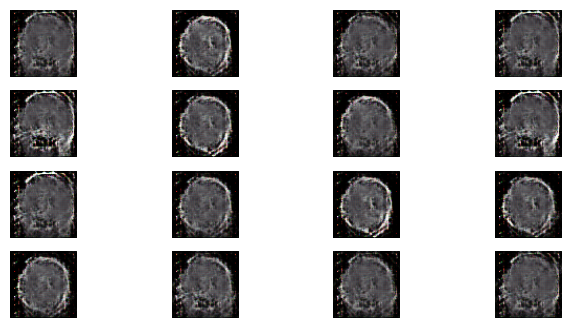

 82%|████████▎ | 33/40 [00:47<00:08,  1.22s/it]

Time for epoch 33 is 1.0401954650878906 sec
Training started with epochs 34 with 39 bateches...
Losses after epoch    34: generator 5.213, discriminator 0.102,  real_score 94.06%, fake_score 3.30%


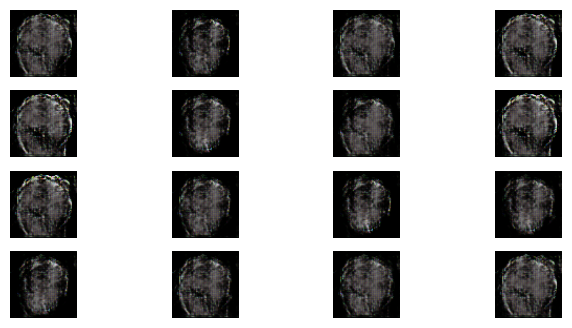

 85%|████████▌ | 34/40 [00:49<00:07,  1.30s/it]

Time for epoch 34 is 1.4839086532592773 sec
Training started with epochs 35 with 39 bateches...
Losses after epoch    35: generator 5.495, discriminator 0.710,  real_score 59.43%, fake_score 0.94%


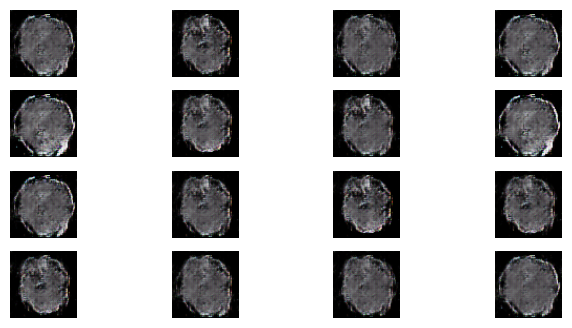

 88%|████████▊ | 35/40 [00:50<00:06,  1.22s/it]

Time for epoch 35 is 1.0234129428863525 sec
Training started with epochs 36 with 39 bateches...
Losses after epoch    36: generator 3.500, discriminator 2.745,  real_score 23.41%, fake_score 8.27%


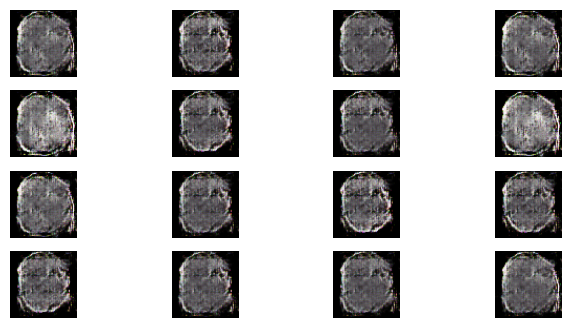

 90%|█████████ | 36/40 [00:51<00:04,  1.23s/it]

Time for epoch 36 is 1.245619535446167 sec
Training started with epochs 37 with 39 bateches...
Losses after epoch    37: generator 3.784, discriminator 0.365,  real_score 85.27%, fake_score 7.03%


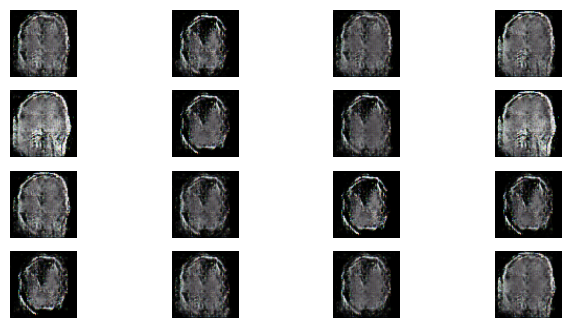

 92%|█████████▎| 37/40 [00:52<00:03,  1.27s/it]

Time for epoch 37 is 1.3735933303833008 sec
Training started with epochs 38 with 39 bateches...
Losses after epoch    38: generator 6.040, discriminator 0.802,  real_score 50.70%, fake_score 0.79%


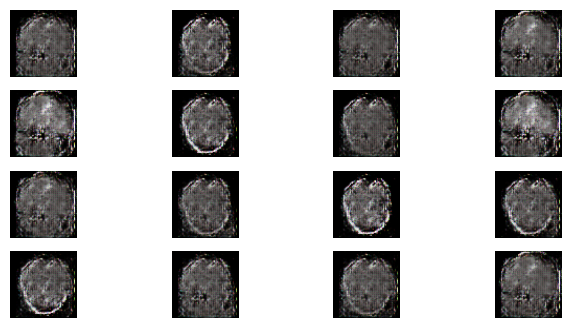

 95%|█████████▌| 38/40 [00:54<00:02,  1.24s/it]

Time for epoch 38 is 1.15278959274292 sec
Training started with epochs 39 with 39 bateches...
Losses after epoch    39: generator 2.590, discriminator 0.915,  real_score 68.72%, fake_score 15.65%


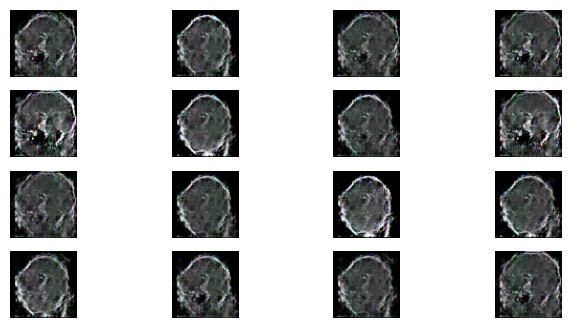

 98%|█████████▊| 39/40 [00:55<00:01,  1.18s/it]

Time for epoch 39 is 1.0499308109283447 sec
Training started with epochs 40 with 39 bateches...
Losses after epoch    40: generator 3.698, discriminator 0.695,  real_score 66.51%, fake_score 9.89%


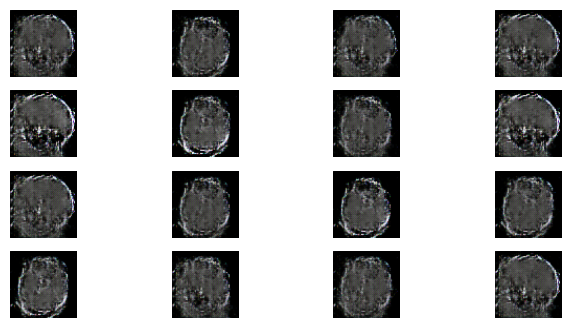

100%|██████████| 40/40 [00:56<00:00,  1.41s/it]

Time for epoch 40 is 1.2274737358093262 sec


In [221]:
from tqdm import tqdm
# start training process
gen_loss_epochs, disc_loss_epochs, real_score_list, fake_score_list=train(train_dataset,epochs=epochs)